# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
from settings import *

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.impedances.wakes import WakeField, WakeTable, Resonator, CircularResonator, ParallelPlatesResonator
from PyHEADTAIL.impedances.wakes import ResistiveWall, CircularResistiveWall, ParallelPlatesResistiveWall
from PyHEADTAIL.trackers.longitudinal_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL.general.printers import SilentPrinter

PyHEADTAIL v1.10.5.276




# Setting up the machine and functions

In [4]:
# Basic parameters.
n_turns = 500
n_segments = 1
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = [0.0003225]

# Parameters for transverse map.
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

# HELPERS
def plot_data(sigma_z, mean, Q, Qs):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.plot(mean, '-', c='b')
    #ax1.plot(mean_y, '-', c='r')
    ax1.set_xlabel('turns')
    ax1.set_ylabel('mean [m]')

    ax2.plot(sigma_z, '-', c='b')
    ax2.set_xlabel('turns')
    ax2.set_ylabel('sigma_z [m]')

    fr_x, ax_x = my_fft(mean)
    markerline, stemlines, baseline = ax3.stem(fr_x, ax_x, label=r'bunch spectrum')
    plt.setp(baseline, 'color','b', 'linewidth', 2)
    ax3.axvline(Q%1, color='r', label='transverse main tune')
    ax3.axvline(Q%1 - Qs, color='g', linestyle='dashed', label=r'1st synchrotron sidebands')
    ax3.axvline(Q%1 + Qs, color='g', linestyle='dashed')
    handles, labels = ax3.get_legend_handles_labels()
    ax3.legend(handles, labels, loc='upper left')
    ax3.set_xlabel('tune')
    ax3.set_ylabel('amplitude')
    ax3.set_xlim((0.25, 0.32))

    plt.show()
    
def track_n_save(bunch, map_):
    mean_x = np.empty(n_turns)
    mean_y = np.empty(n_turns)
    sigma_z = np.empty(n_turns)
    
    for i in xrange(n_turns):
        mean_x[i] = bunch.mean_x()
        mean_y[i] = bunch.mean_y()
        sigma_z[i] = bunch.sigma_z()

        for m_ in map_:
            m_.track(bunch)

    return mean_x, mean_y, sigma_z

def my_fft(data):
    t = np.arange(len(data))
    fft = np.fft.rfft(data)
    fft_freq = np.fft.rfftfreq(t.shape[-1])
    
    return fft_freq, np.abs(fft.real)

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Q_s))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    # print ('bunch sigma_z=' + bunch.sigma_z())
    
    return bunch

def track_n_show(bunch, slicer, map_woWakes, wake_field):
    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(16,16))

    xp_diff  = np.zeros(n_macroparticles)

    for i in xrange(n_turns):
        for m_ in map_woWakes:
            m_.track(bunch)

        # Dipole X kick.
        if i == (n_turns - 1):
            xp_old = bunch.xp.copy()
        wake_field.track(bunch)

        if i == (n_turns - 1):
            xp_diff[:] = bunch.xp[:] - xp_old[:]

    # Plot bunch.z vs. slice index of particle. Mark particles within
    # z cuts in green.
    nsigmaz_lbl = ' (nsigmaz =' + str(n_sigma_z) + ')'

    slice_set = bunch.get_slices(slicer)
    pidx = slice_set.particles_within_cuts
    slidx = slice_set.slice_index_of_particle

    z_cut_tail, z_cut_head = slice_set.z_cut_tail, slice_set.z_cut_head
    
    ax1.plot(slidx, bunch.z, '.r', ms=10, label='all particles')
    ax1.plot(slidx.take(pidx), bunch.z.take(pidx), '.g', label='particles within z cuts')
    ax1.axhline(z_cut_tail, color='m', linestyle='dashed', label='slicer boundaries')
    ax1.axhline(z_cut_head, color='m', linestyle='dashed')
    ax1.axvline(0, color='b', linestyle='dashed', label='first and last slices')
    ax1.axvline(slice_set.n_slices-1, color='b', linestyle='dashed')
    [ ax1.axhline(z, color='m', linestyle='dashed') for z in slice_set.z_bins ]
    ax1.legend(loc='upper left')

    # Show dipole and qudrupole kicks applied for each particle for the
    # last turn.
    #ax13.plot(slidx, xp_diff_quad, '.g', ms=10, label='quad x kicks')
    ax2.plot(slidx, xp_diff, '.r', label='x kicks')
    ax2.axvline(0, color='b', linestyle='dashed', label='first and last slices')
    ax2.axvline(n_slices-1, color='b', linestyle='dashed')
    ax2.axhline(0, color='black', ls='dashed')
    #ax13.axvline(0, color='b', linestyle='dashed', label='first and last slices' + nsigmaz_lbl)
    #ax13.axvline(n_slices-1, color='b', linestyle='dashed')
    ax2.legend(loc='lower right')
    #ax13.legend(loc='lower right')

    xmax = max(slidx)
    xmax += 2
    xmin = min(slidx)
    xmin -= 2

    ymax = max(xp_diff)
    ymax += ymax*0.2
    ymin = min(xp_diff)
    ymin += ymin*0.2

    ax1.set_xlim((xmin, xmax))
    ax2.set_xlim((xmin, xmax))
    #ax13.set_xlim((xmin, xmax))
    
    plt.show()
    
def show_sampled_wake(bunch, slicer, wake_table, wake_component):
    slice_set = bunch.get_slices(slicer)
        
    fig, ax1 = plt.subplots(1, 1, figsize=(16,10))
    
    # Plot wake table and show where wake is sampled (values obtained from interp1d)
    # for dipole and quadrupole X kicks.
    ax1.plot(1e-9*wake_table.wake_table['time'][:-1], abs(1e15*wake_table.wake_table[wake_component][:-1]),
              color='b')
    #ax21.plot(wake_table.wake_table['time'][:-1], abs(wake_table.wake_table['quadrupole_x'][:-1]),
    #          color='r', label='quadrupole x')

    sampled_wake = wake_table.function_transverse(wake_component)
    dt = np.concatenate((slice_set.convert_to_time(slice_set.z_centers) - 
                         slice_set.convert_to_time(slice_set.z_centers[-1]),
                        (slice_set.convert_to_time(slice_set.z_centers) -
                         slice_set.convert_to_time(slice_set.z_centers[0]))[1:]))

    ax1.plot(abs(dt), abs(sampled_wake(dt)), '.g', ms=15,
              label='sampled and interpolated wake')

    slice_width = (slice_set.z_cut_head - slice_set.z_cut_tail) / slice_set.n_slices
    dzz = np.arange(0, n_slices*slice_width, slice_width)
    [ ax1.axvline(z / (bunch.beta * c), color='black', ls='dashed') for z in dzz[1:] ]
    ax1.axvline(dzz[0] / (bunch.beta * c), color='black', ls='dashed', label='slice widths')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('abs. wake strength [V/C/m]')
    ax1.legend(loc='upper right')

    ax1.set_xlim((1e-9*wake_table.wake_table['time'][0], 1e-9*wake_table.wake_table['time'][-2]))
    
    plt.show()

# Let's go

In [5]:
# Error cases
# (I) for WakeTable. Number of wake_file_columns does not correspond to that
# of the wake_file.
try:
    wake_file_columns = ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y',
                         'dipole_xy', 'dipole_yx', 'nonsense' ]
    table = WakeTable('./wake_table.dat', wake_file_columns)
    print ('test NOT passed. No error raised!')
except ValueError as exc:
    print ('test passed: the expected ValueError due to mismatched column contents ' +
            'vs column description occured.\n')
    print ('Error message:\n' + str(exc))

test passed: the expected ValueError due to mismatched column contents vs column description occured.

Error message:
Length of wake_file_columns list does not correspond to the number of columns in the specified wake_file. 



In [6]:
# Error cases
# (II) for WakeTable. No wake_file_column 'time' defined.
try:
    wake_file_columns = ['nonsense', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y',
                         'dipole_xy', 'dipole_yx' ]
    table = WakeTable('./wake_table.dat', wake_file_columns)
    print ('test NOT passed. No error raised!')
except ValueError as exc:
    print ('test passed: the expected ValueError due to missing \'time\' column occured.\n ')
    print ('Error message:\n' + str(exc))

test passed: the expected ValueError due to missing 'time' column occured.
 
Error message:
No wake_file_column with name 'time' has been specified. 



In [7]:
# CASE TEST SETUP
trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
long_map = LinearMap(alpha_0, C, Q_s)

bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    long_map)

dipole_x Assuming ultrarelativistic wake.


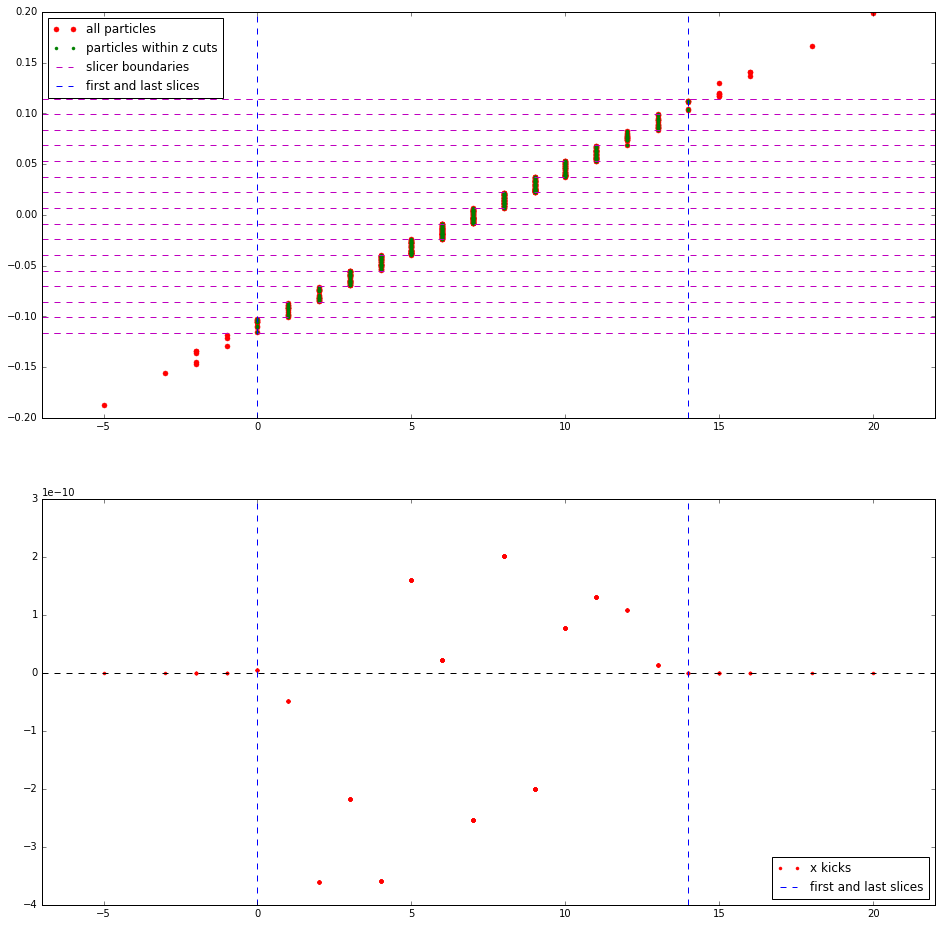

dipole_x Assuming ultrarelativistic wake.


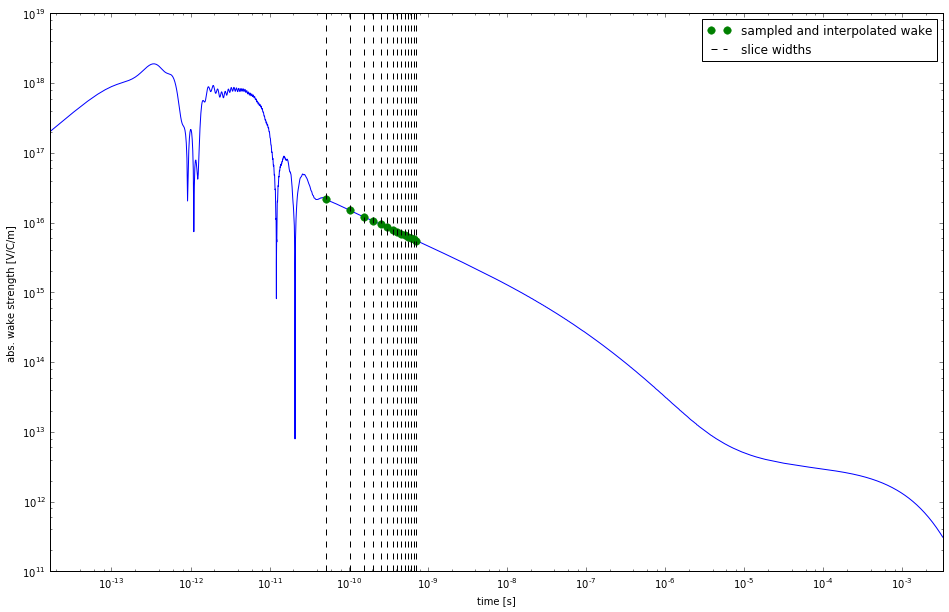

In [8]:
# CASE I
# Transverse and long. tracking (linear), and wakes from WakeTable source.
# DIPOLE X, UniformBinSlicer

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
wake_file_columns = ['time', 'dipole_x', 'no_dipole_y', 'no_quadrupole_x', 'no_quadrupole_y',
                     'no_dipole_xy', 'no_dipole_yx']
table = WakeTable('./wake_table.dat', wake_file_columns, 
                  warningprinter=SilentPrinter())
wake_field = WakeField(uniform_bin_slicer, table)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)
show_sampled_wake(bunch, uniform_bin_slicer, table, wake_component='dipole_x')

dipole_x Assuming ultrarelativistic wake.


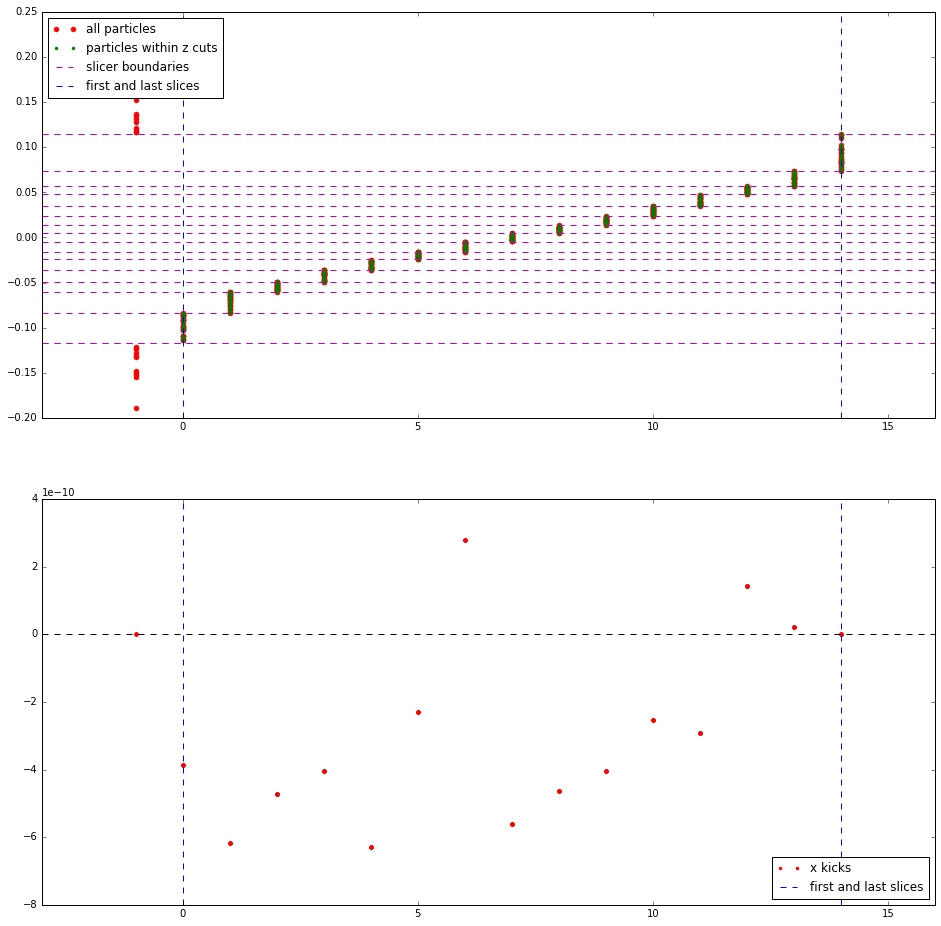

dipole_x Assuming ultrarelativistic wake.


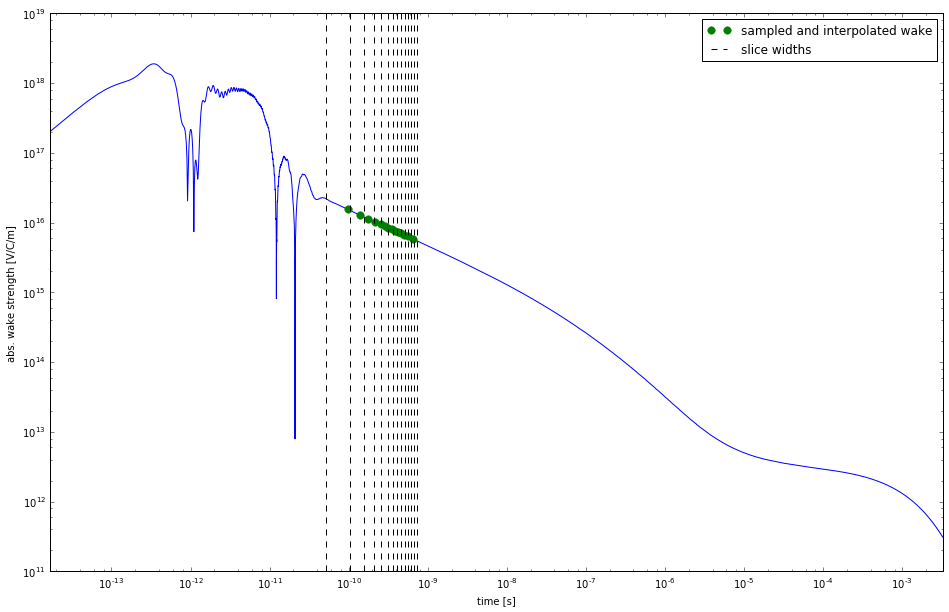

In [9]:
# CASE II
# Transverse and long. tracking (linear), and wakes from WakeTable source.
# DIPOLE X, UniformChargeSlicer

n_sigma_z = 2
n_slices = 15
uniform_charge_slicer = UniformChargeSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
wake_file_columns = ['time', 'dipole_x', 'no_dipole_y', 'no_quadrupole_x', 'no_quadrupole_y',
                     'no_dipole_xy', 'no_dipole_yx']
table = WakeTable('./wake_table.dat', wake_file_columns, 
                  warningprinter=SilentPrinter())
wake_field = WakeField(uniform_charge_slicer, table)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_charge_slicer, map_woWakes, wake_field)
show_sampled_wake(bunch, uniform_charge_slicer, table, wake_component='dipole_x')

quadrupole_x Assuming ultrarelativistic wake.


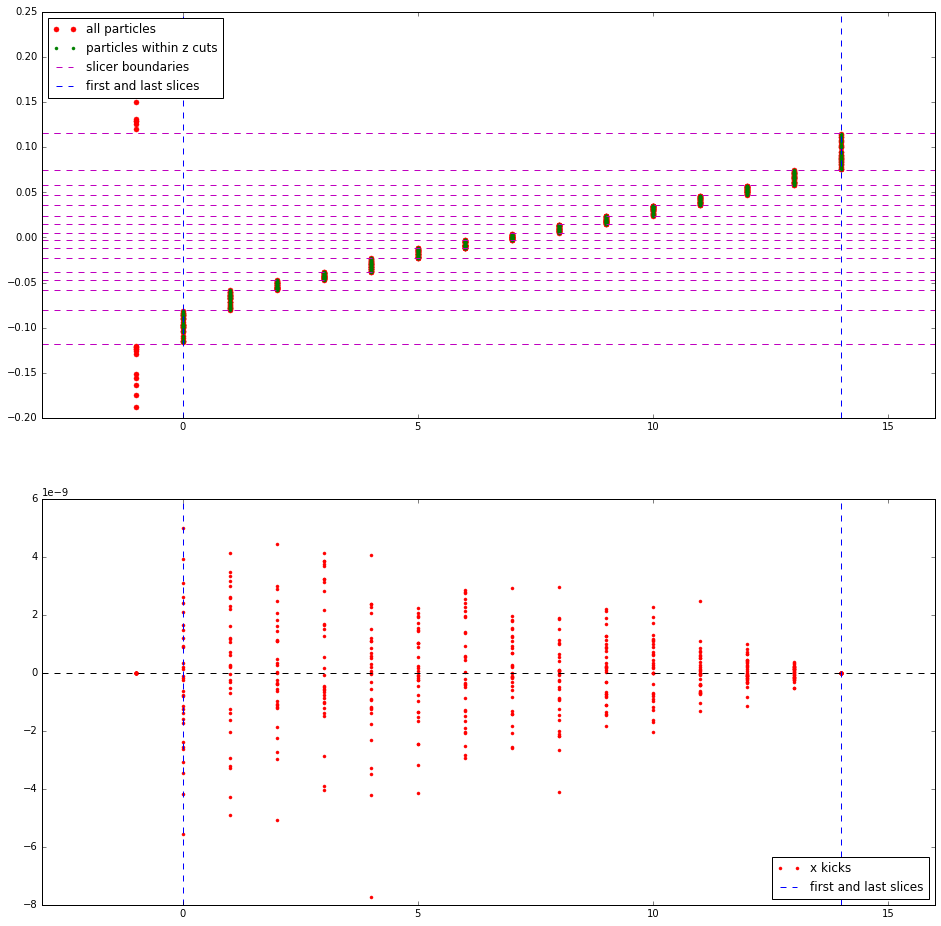

quadrupole_x Assuming ultrarelativistic wake.


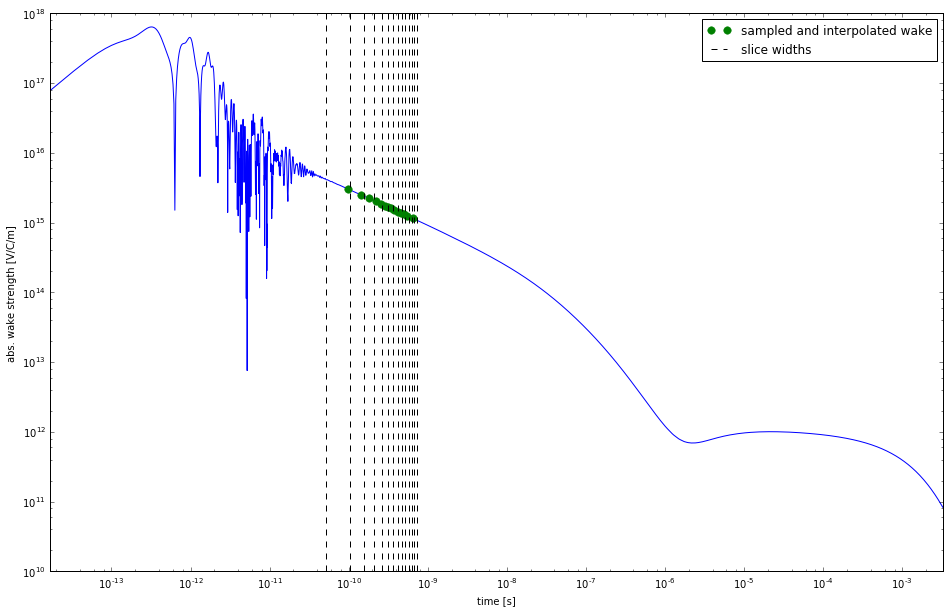

In [10]:
# CASE III
# Transverse and long. tracking (linear), and wakes from WakeTable source.
# Quadrupole X, UniformChargeSlicer

n_sigma_z = 2
n_slices = 15
uniform_charge_slicer = UniformChargeSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
wake_file_columns = ['time', 'no_dipole_x', 'no_dipole_y', 'quadrupole_x', 'no_quadrupole_y',
                     'no_dipole_xy', 'no_dipole_yx']
table = WakeTable('./wake_table.dat', wake_file_columns,
                  warningprinter=SilentPrinter())
wake_field = WakeField(uniform_charge_slicer, table)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_charge_slicer, map_woWakes, wake_field)
show_sampled_wake(bunch, uniform_charge_slicer, table, wake_component='quadrupole_x')

quadrupole_x Assuming ultrarelativistic wake.


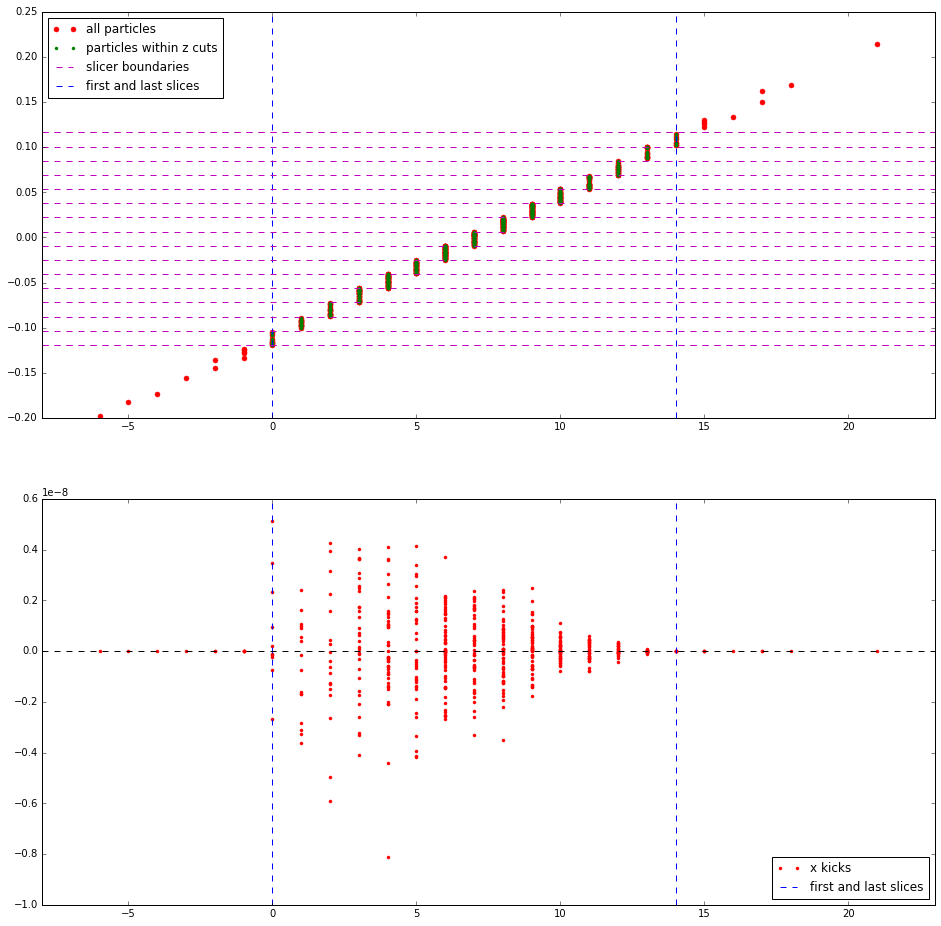

quadrupole_x Assuming ultrarelativistic wake.


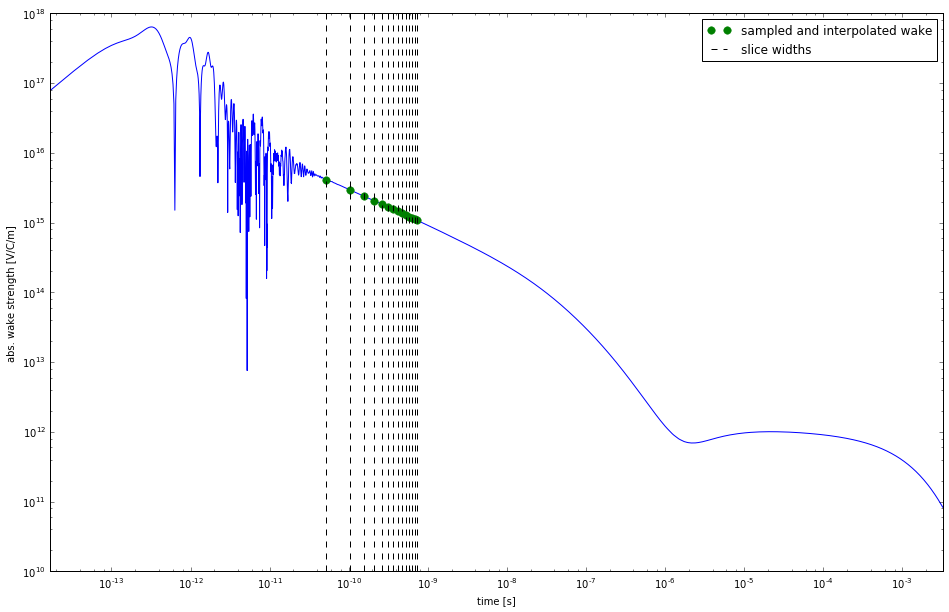

In [11]:
# CASE IV
# Transverse and long. tracking (linear), and wakes from WakeTable source.
# Quadrupole X, UniformBinSlicer

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
wake_file_columns = ['time', 'no_dipole_x', 'no_dipole_y', 'quadrupole_x', 'no_quadrupole_y',
                     'no_dipole_xy', 'no_dipole_yx']
table = WakeTable('./wake_table.dat', wake_file_columns,
                  warningprinter=SilentPrinter())
wake_field = WakeField(uniform_bin_slicer, table)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)
show_sampled_wake(bunch, uniform_bin_slicer, table, wake_component='quadrupole_x')

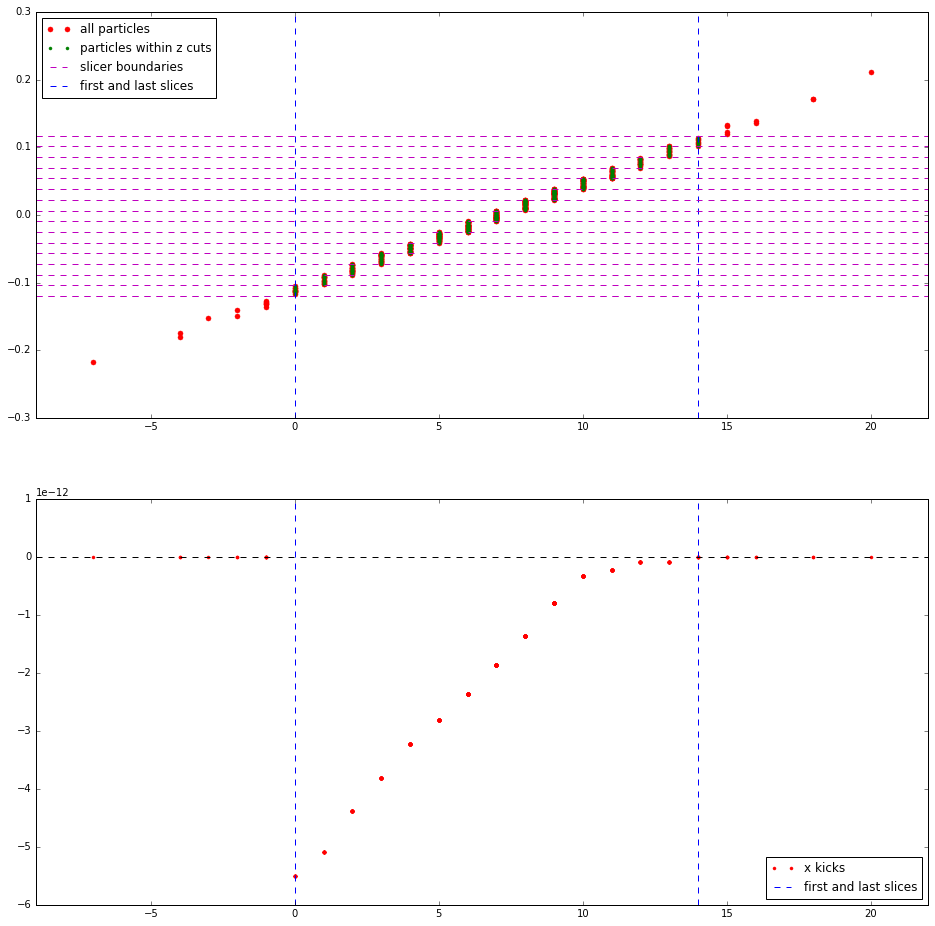

In [12]:
# CASE V
# Transverse and long. tracking (linear),
# Resonator circular

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
reson_circ = CircularResonator(R_shunt=1e6, frequency=1e8, Q=1)
wake_field = WakeField(uniform_bin_slicer, reson_circ)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

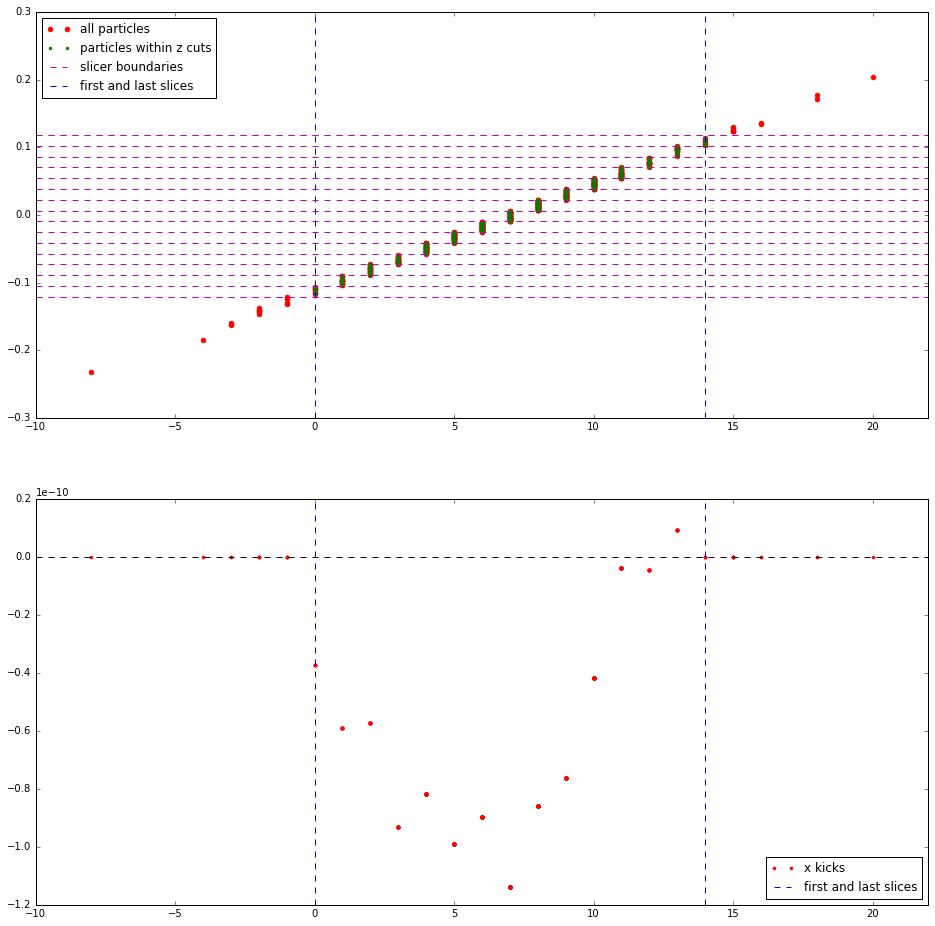

In [13]:
# CASE V b.
# Transverse and long. tracking (linear),
# Several Resonators circular

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
reson_circ = CircularResonator(R_shunt=1e6, frequency=1e8, Q=1)
reson_circ2 = CircularResonator(R_shunt=1e6, frequency=1e9, Q=0.8)
reson_circ3 = CircularResonator(R_shunt=5e6, frequency=1e6, Q=0.2)

wake_field = WakeField(uniform_bin_slicer, reson_circ, reson_circ2, reson_circ3)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

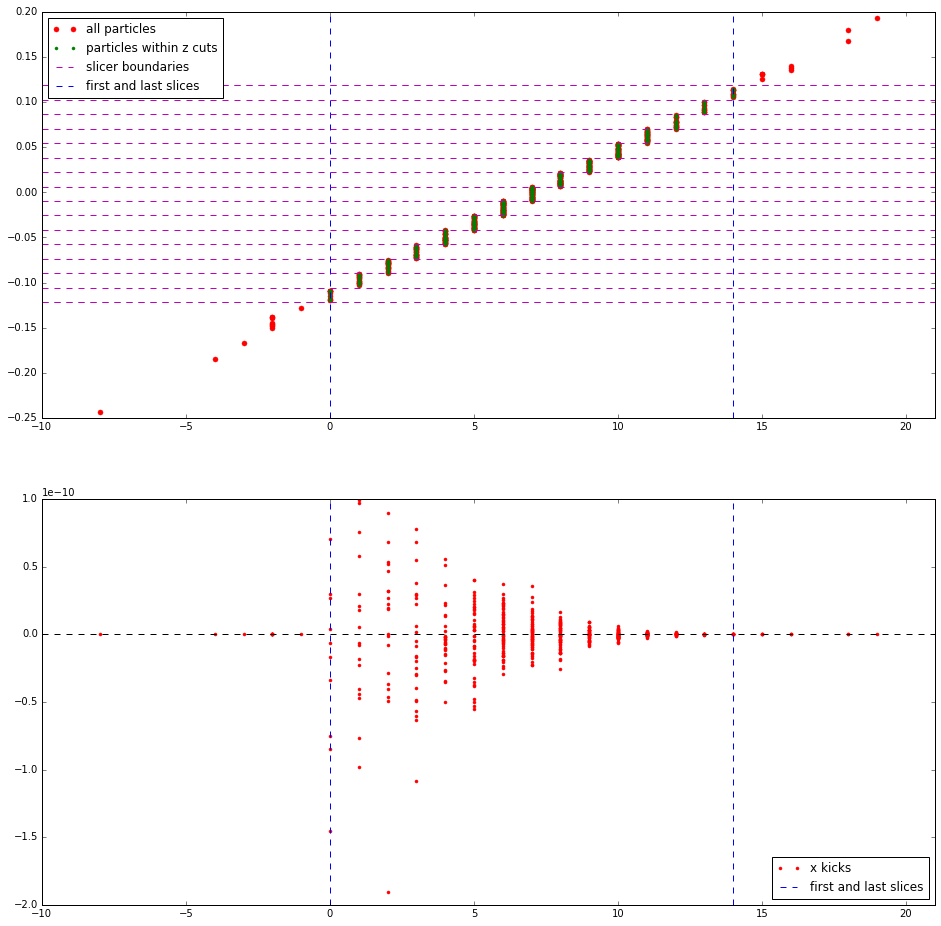

In [14]:
# CASE V c.
# Transverse and long. tracking (linear),
# Resonator parallel_plates

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
reson_para = ParallelPlatesResonator(R_shunt=1e6, frequency=1e8, Q=1)
wake_field = WakeField(uniform_bin_slicer, reson_para)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

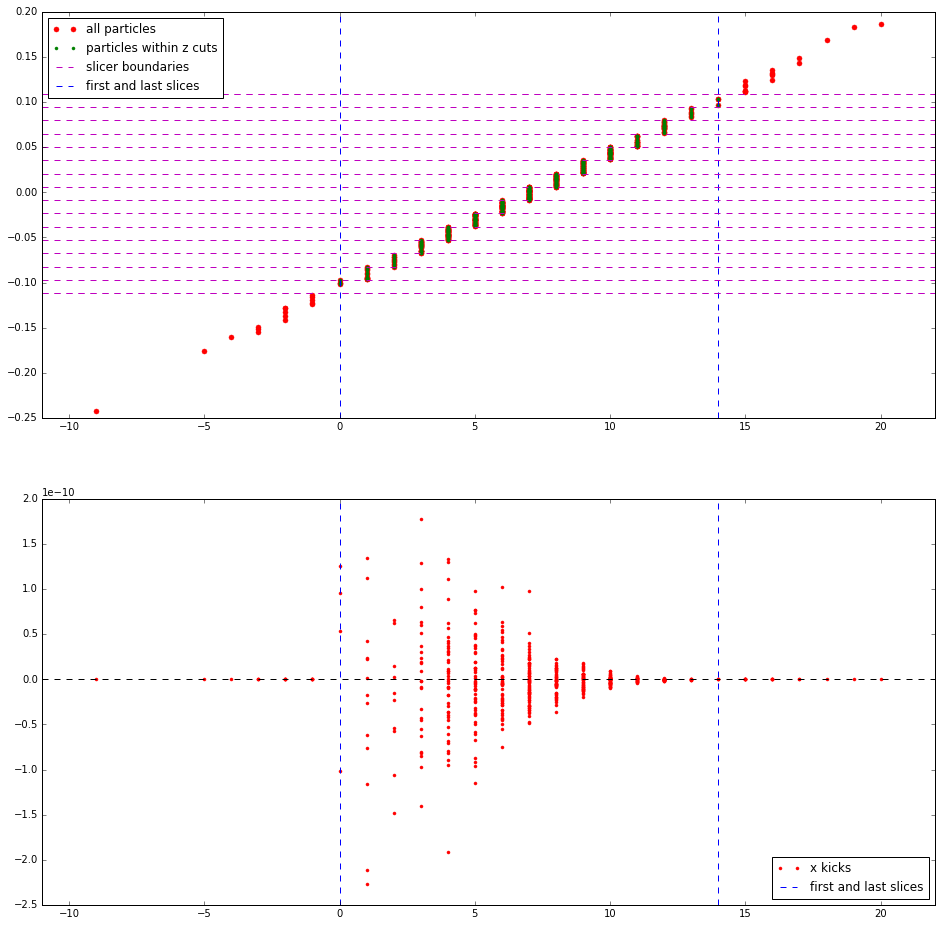

In [15]:
# CASE V d.
# Transverse and long. tracking (linear),
# Resonator w. longitudinal wake

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
reson = Resonator(R_shunt=1e6, frequency=1e8, Q=1, Yokoya_X1=1, Yokoya_X2=1, Yokoya_Y1=1, Yokoya_Y2=1, switch_Z=True)
wake_field = WakeField(uniform_bin_slicer, reson)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

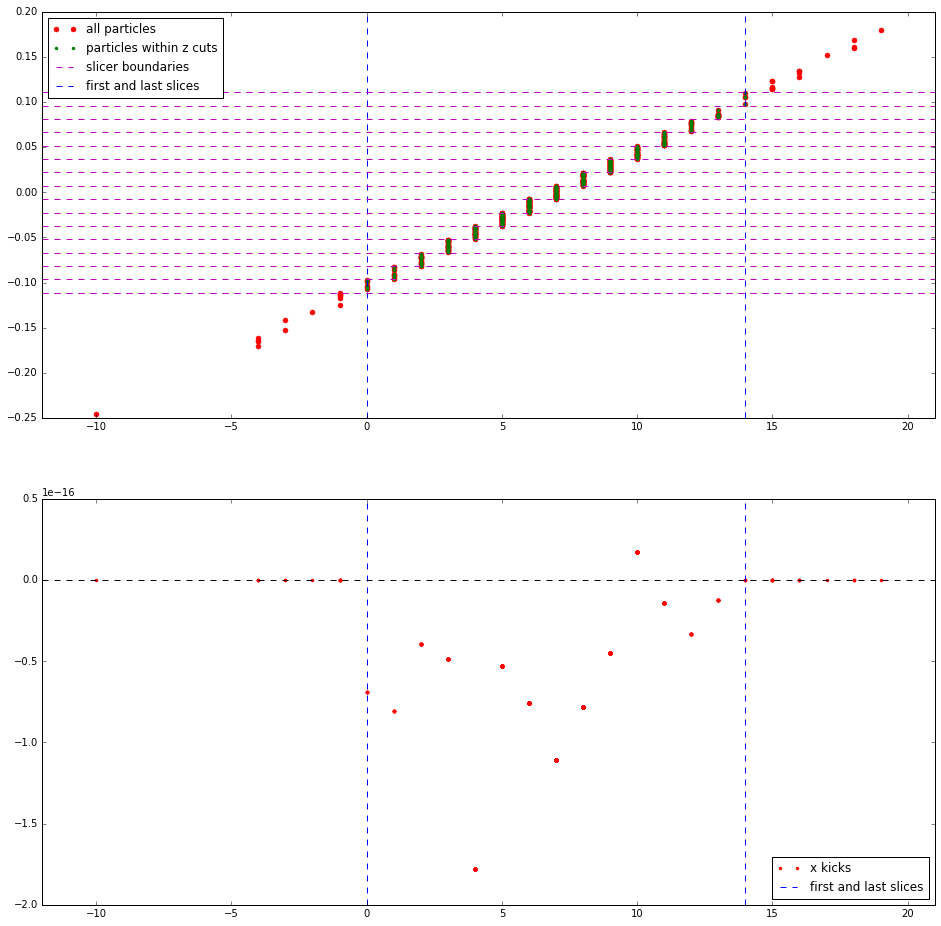

In [16]:
# CASE VI
# Transverse and long. tracking (linear),
# ResistiveWall circular

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
resis_circ = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C,
                                    conductivity=1e6, dt_min=1e-3/c)
wake_field = WakeField(uniform_bin_slicer, resis_circ)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

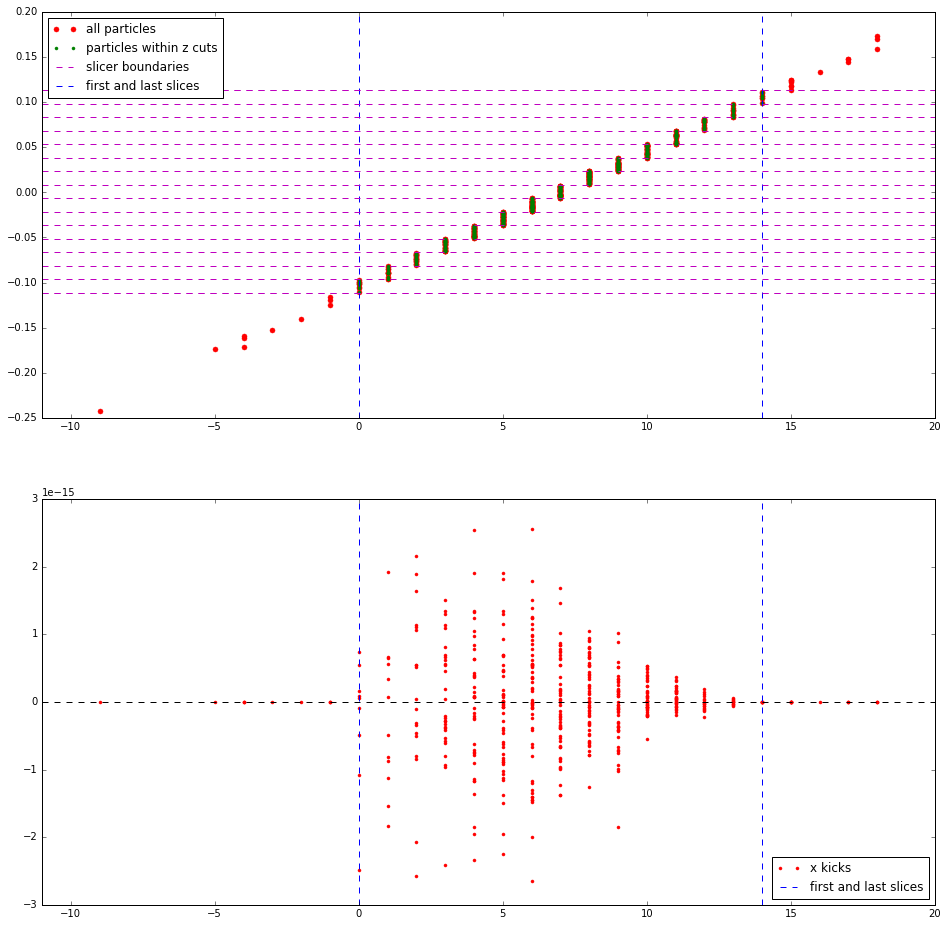

In [17]:
# CASE VI b.
# Transverse and long. tracking (linear),
# ResistiveWall parallel_plates

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
resis_para = ParallelPlatesResistiveWall(pipe_radius=5e-2, resistive_wall_length=C,
                                    conductivity=1e6, dt_min=1e-3/c)
wake_field = WakeField(uniform_bin_slicer, resis_para)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)

dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


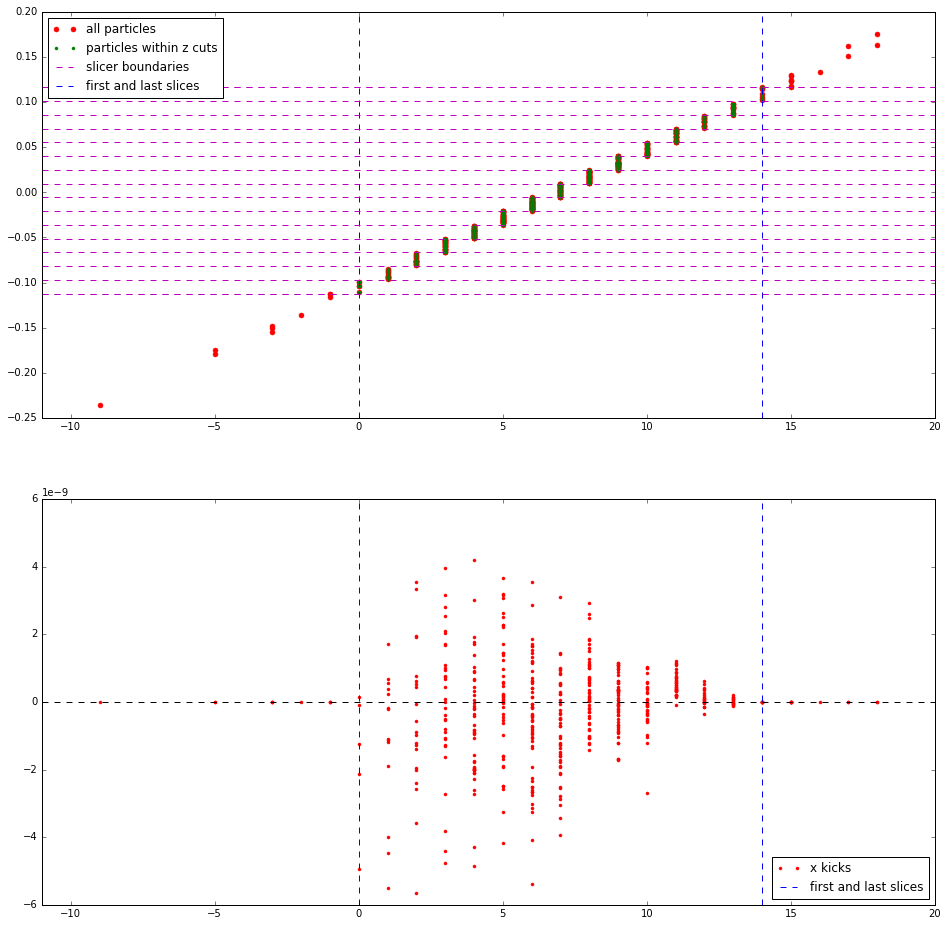

In [18]:
# CASE VII.
# Transverse and long. tracking (linear),
# Pass mixture of WakeSources to define WakeField.

n_sigma_z = 2
n_slices = 15
uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
resis_circ = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C,
                                    conductivity=1e6, dt_min=1e-3/c)
reson_para = ParallelPlatesResonator(R_shunt=1e6, frequency=1e8, Q=1)
wake_file_columns = ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y',
                     'dipole_xy', 'dipole_yx']
table = WakeTable('./wake_table.dat', wake_file_columns,
                  warningprinter=SilentPrinter())

wake_field = WakeField(uniform_bin_slicer, resis_circ, reson_para, table)
for i in wake_field.wake_kicks:
    print (i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

track_n_show(bunch, uniform_bin_slicer, map_woWakes, wake_field)